STOCK SCREENING

- Webscraping for relevant information on the stocks
- Find highest ranking stocks based on the daily trading volumes 

In [1]:
"""Importing relevant packages"""

import yahoo_fin.stock_info as ya
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import numpy as np
import os

In [2]:
# Get the 100 most traded stocks for the trading day
movers = ya.get_day_most_active()
movers.head()

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,AAPL,Apple Inc.,113.02,-3.77,-3.23,144466000.0,172071000.0,1.933T1.933T1.933T1.933T1.933T1.933T1.933T1.93...,34.29
1,AAL,American Airlines Group Inc.,13.00,0.42,3.34,111689000.0,66954000.0,6.547e+09,NaN
2,NIO,NIO Limited,21.18,-0.58,-2.67,91631000.0,134688000.0,2.5895e+10,NaN
3,GE,General Electric Company,6.39,0.15,2.40,89199000.0,89105000.0,5.5934e+10,NaN
4,TSLA,"Tesla, Inc.",415.09,-33.07,-7.38,71212000.0,80578000.0,3.86785e+11,1075.36


In [3]:
movers = movers[movers['% Change'] >= 0]
movers.head()

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
1,AAL,American Airlines Group Inc.,13.00,0.42,3.34,111689000.0,66954000.0,6.547e+09,NaN
3,GE,General Electric Company,6.39,0.15,2.40,89199000.0,89105000.0,5.5934e+10,NaN
5,NKLA,Nikola Corporation,24.25,0.14,0.58,64597000.0,32018000.0,9.19e+09,NaN
6,F,Ford Motor Company,6.89,0.14,2.07,59911000.0,62989000.0,2.7411e+10,NaN
9,BAC,Bank of America Corporation,24.21,0.11,0.46,50774000.0,59501000.0,2.09758e+11,11.65


In [4]:
res = requests.get('http://www.sentdex.com/financial-analysis/?tf=30d')
soup = BeautifulSoup(res.text)
table = soup.find_all('tr')
# Initialize empty lists to store stock symbol, sentiment and mentions
stock = []
sentiment = []
mentions = []
sentiment_trend = []
# Use try and except blocks to mitigate missing data
for ticker in table:
    ticker_info = ticker.find_all('td')
    
    try:
        stock.append(ticker_info[0].get_text())
    except:
        stock.append(None)
    try:
        sentiment.append(ticker_info[3].get_text())
    except:
        sentiment.append(None)
    try:
        mentions.append(ticker_info[2].get_text())
    except:
        mentions.append(None)
    try:
        if (ticker_info[4].find('span',{"class":"glyphicon  glyphicon-chevron-up"})):
            sentiment_trend.append('up')
        else:
            sentiment_trend.append('down')
    except:
        sentiment_trend.append(None)

In [5]:
company_info = pd.DataFrame(list(zip(stock,sentiment,sentiment_trend,mentions)),columns =['Symbol','Sentiment','direction','Mentions'])

In [6]:
company_info.head()

,Symbol,Sentiment,direction,Mentions
0,None,None,None,None
1,SP500,very good,down,124814
2,NOK,very good,down,8996
3,SNE,good,down,1616
4,MAT,very good,down,1309


In [7]:
top_stocks = movers.merge(company_info, on='Symbol', how='left')
top_stocks.drop(['Market Cap','PE Ratio (TTM)'], axis=1, inplace=True)
top_stocks

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Sentiment,direction,Mentions
0,AAL,American Airlines Group Inc.,13.00,0.4200,3.34,111689000.0,66954000.0,NaN,NaN,NaN
1,GE,General Electric Company,6.39,0.1500,2.40,89199000.0,89105000.0,very good,down,318
2,NKLA,Nikola Corporation,24.25,0.1400,0.58,64597000.0,32018000.0,NaN,NaN,NaN
3,F,Ford Motor Company,6.89,0.1400,2.07,59911000.0,62989000.0,poor,down,325
4,BAC,Bank of America Corporation,24.21,0.1100,0.46,50774000.0,59501000.0,poor,down,316
5,UAL,"United Airlines Holdings, Inc.",36.01,0.8300,2.36,35053000.0,37188000.0,NaN,NaN,NaN
6,MRO,Marathon Oil Corporation,4.12,0.1700,4.30,29648000.0,25215000.0,good,down,320
7,BBBY,Bed Bath & Beyond Inc.,20.60,1.8500,9.90,33554000.0,11404000.0,good,down,333
8,BA,The Boeing Company,168.08,0.2200,0.13,30942000.0,29102000.0,good,down,318
9,CCL,Carnival Corporation & Plc,15.16,0.1300,0.86,30609000.0,36900000.0,good,down,315


In [8]:
res = requests.get("https://www.tradefollowers.com/strength/twitter_strongest.jsp?tf=1m")
soup = BeautifulSoup(res.text)

stock_twitter = soup.find_all('tr')

In [9]:
twit_stock = []
sector = []
twit_score = []

for stock in stock_twitter:
    try:
        score = stock.find_all("td",{"class": "datalistcolumn"})
        twit_stock.append(score[0].get_text().replace('$','').strip())
        sector.append(score[2].get_text().replace('\n','').strip())
        twit_score.append(score[4].get_text().replace('\n','').strip())
    except:
        twit_stock.append(np.nan)
        sector.append(np.nan)
        twit_score.append(np.nan)
        
twitter_df = pd.DataFrame({'Symbol': twit_stock, 'Sector': sector, 'Twit_Bull_score': twit_score})

# Remove NA values 
twitter_df.dropna(inplace=True)
twitter_df.drop_duplicates(subset ="Symbol", 
                     keep = 'first', inplace = True)
twitter_df.reset_index(drop=True,inplace=True)
twitter_df

,Symbol,Sector,Twit_Bull_score
0,BA,Capital Goods,"2,129"
1,AMD,Technology,"1,926"
2,NVDA,Technology,"1,799"
3,WMT,Consumer Services,"1,763"
4,NFLX,Consumer Services,"1,288"
5,BABA,Consumer Services,"1,190"
6,TWTR,Technology,"1,156"
7,SQ,Technology,"1,147"
8,CCL,Transportation,854
9,ORCL,Technology,829


In [10]:
Final_list = top_stocks.merge(twitter_df, on='Symbol', how='left')
#top_stocks.drop(['Market Cap','PE Ratio (TTM)'], axis=1, inplace=True)
Final_list

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Sentiment,direction,Mentions,Sector,Twit_Bull_score
0,AAL,American Airlines Group Inc.,13.00,0.4200,3.34,111689000.0,66954000.0,NaN,NaN,NaN,NaN,NaN
1,GE,General Electric Company,6.39,0.1500,2.40,89199000.0,89105000.0,very good,down,318,Consumer Durables,530
2,NKLA,Nikola Corporation,24.25,0.1400,0.58,64597000.0,32018000.0,NaN,NaN,NaN,NaN,NaN
3,F,Ford Motor Company,6.89,0.1400,2.07,59911000.0,62989000.0,poor,down,325,Capital Goods,448
4,BAC,Bank of America Corporation,24.21,0.1100,0.46,50774000.0,59501000.0,poor,down,316,Finance,469
5,UAL,"United Airlines Holdings, Inc.",36.01,0.8300,2.36,35053000.0,37188000.0,NaN,NaN,NaN,Transportation,418
6,MRO,Marathon Oil Corporation,4.12,0.1700,4.30,29648000.0,25215000.0,good,down,320,NaN,NaN
7,BBBY,Bed Bath & Beyond Inc.,20.60,1.8500,9.90,33554000.0,11404000.0,good,down,333,NaN,NaN
8,BA,The Boeing Company,168.08,0.2200,0.13,30942000.0,29102000.0,good,down,318,Capital Goods,"2,129"
9,CCL,Carnival Corporation & Plc,15.16,0.1300,0.86,30609000.0,36900000.0,good,down,315,Transportation,854


In [11]:
res2 = requests.get("https://www.tradefollowers.com/active/twitter_active.jsp?tf=1m")
soup2 = BeautifulSoup(res2.text)

stock_twitter2 = soup2.find_all('tr')

In [12]:
twit_stock2 = []
sector2 = []
twit_score2 = []

for stock in stock_twitter2:
    try:
        score2 = stock.find_all("td",{"class": "datalistcolumn"})
        
         
        
        twit_stock2.append(score2[0].get_text().replace('$','').strip())
        sector2.append(score2[2].get_text().replace('\n','').strip())
        twit_score2.append(score2[4].get_text().replace('\n','').strip())
    except:
        twit_stock2.append(np.nan)
        sector2.append(np.nan)
        twit_score2.append(np.nan)
        
twitter_df2 = pd.DataFrame({'Symbol': twit_stock2, 'Sector': sector2, 'Twit_mom': twit_score2})

# Remove NA values 
twitter_df2.dropna(inplace=True)
twitter_df2.drop_duplicates(subset ="Symbol", 
                     keep = 'first', inplace = True)
twitter_df2.reset_index(drop=True,inplace=True)
twitter_df2

,Symbol,Sector,Twit_mom
0,TSLA,Capital Goods,"37,565"
1,AAPL,Technology,"17,897"
2,AMZN,Consumer Services,"8,564"
3,MSFT,Technology,"6,144"
4,FB,Technology,"5,604"
5,AMD,Technology,"5,008"
6,BA,Capital Goods,"4,751"
7,NVDA,Technology,"4,644"
8,NFLX,Consumer Services,"3,682"
9,WMT,Consumer Services,"3,513"


In [13]:
Recommender_list = Final_list.merge(twitter_df2, on='Symbol', how='left')
Recommender_list.drop(['Volume','Avg Vol (3 month)'],axis=1, inplace=True)
Recommender_list

,Symbol,Name,Price (Intraday),Change,% Change,Sentiment,direction,Mentions,Sector_x,Twit_Bull_score,Sector_y,Twit_mom
0,AAL,American Airlines Group Inc.,13.00,0.4200,3.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GE,General Electric Company,6.39,0.1500,2.40,very good,down,318,Consumer Durables,530,Consumer Durables,"1,030"
2,NKLA,Nikola Corporation,24.25,0.1400,0.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F,Ford Motor Company,6.89,0.1400,2.07,poor,down,325,Capital Goods,448,Capital Goods,939
4,BAC,Bank of America Corporation,24.21,0.1100,0.46,poor,down,316,Finance,469,Finance,"1,289"
5,UAL,"United Airlines Holdings, Inc.",36.01,0.8300,2.36,NaN,NaN,NaN,Transportation,418,Transportation,730
6,MRO,Marathon Oil Corporation,4.12,0.1700,4.30,good,down,320,NaN,NaN,NaN,NaN
7,BBBY,Bed Bath & Beyond Inc.,20.60,1.8500,9.90,good,down,333,NaN,NaN,Consumer Services,639
8,BA,The Boeing Company,168.08,0.2200,0.13,good,down,318,Capital Goods,"2,129",Capital Goods,"4,751"
9,CCL,Carnival Corporation & Plc,15.16,0.1300,0.86,good,down,315,Transportation,854,Transportation,"1,483"


{'Information': 'US Sector Performance (realtime & historical)', 'Last Refreshed': '2020-10-05 03:31:07 US/Eastern'}


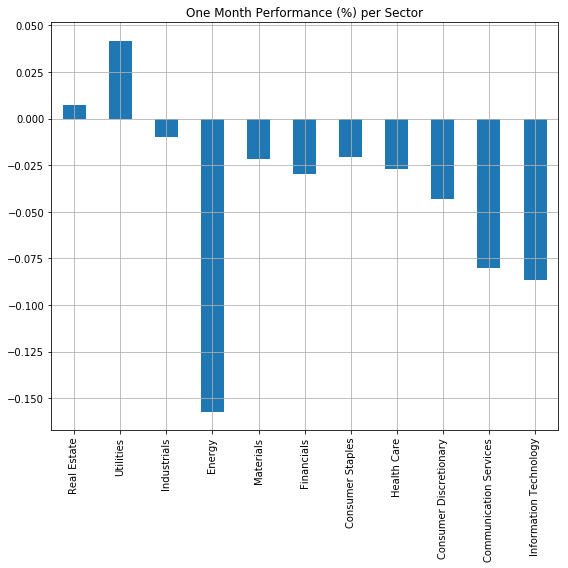

In [14]:
sp = SectorPerformances(key='QYGL0ZGLQLAKBXO1', output_format='pandas')
plt.figure(figsize=(8,8))
data, meta_data = sp.get_sector()
print(meta_data)
data['Rank D: Month Performance'].plot(kind='bar')
plt.title('One Month Performance (%) per Sector')
plt.tight_layout()
plt.grid()
plt.show()

FORECASTING

- Forecast on RELIANCE using LSTM and other algorithms

In [16]:
dt = web.DataReader('RELIANCE.BO','yahoo')
dt.reset_index(inplace=True)

In [17]:
dt['ser'] = [x for x in range(dt.shape[0])]
dt.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ser
0,2015-10-07,458.500000,445.024994,447.899994,456.924988,641720.0,437.556091,0
1,2015-10-08,457.500000,443.299988,457.075012,444.575012,587150.0,425.729584,1
2,2015-10-09,452.450012,441.049988,448.424988,443.174988,505952.0,424.388916,2
3,2015-10-12,450.325012,444.250000,445.000000,446.024994,288826.0,427.118103,3
4,2015-10-13,447.500000,441.500000,443.899994,446.274994,255080.0,427.357513,4


In [18]:
dt['SMA'] = dt['Close'].rolling(10, min_periods=10).mean()
dt['EMA'] = dt['Close'].ewm(span=10, min_periods=10, adjust=False).mean()

std = dt['Close'].rolling(10, min_periods=10).std() 

dt['Real Upper Band'] = dt['SMA'] + (std * 2)
dt['Real Lower Band'] = dt['SMA'] - (std * 2)

Calculate Relative Strength index and On-Balance Volume

In [19]:
def RSIfun(ds, n=10):
    delta = ds['Close'].diff()
    #-----------
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(n, min_periods=n).mean()
    RolDown = dDown.rolling(n, min_periods=n).mean().abs()

    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    return rsi

def OBV(df, n):
    """Calculate On-Balance Volume for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    OBV = [0]
    while i < df.shape[0]-1:
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] > 0:
            OBV.append(df.loc[i + 1, 'Volume'])
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] == 0:
            OBV.append(0)
        if df.loc[i + 1, 'Close'] - df.loc[i, 'Close'] < 0:
            OBV.append(-df.loc[i + 1, 'Volume'])
        i = i + 1
    OBV = pd.Series(OBV)
    OBV_ma = pd.Series(OBV.rolling(n, min_periods=n).mean(), name='OBV_' + str(n))
    return OBV_ma

dt['RSI'] = RSIfun(dt)
dt['OBV'] = OBV(dt, 10)

In [20]:
dt[5:20]

,Date,High,Low,Open,Close,Volume,Adj Close,ser,SMA,EMA,Real Upper Band,Real Lower Band,RSI,OBV
5,2015-10-14,452.000000,446.149994,446.575012,451.000000,334812.0,431.882263,5,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-10-15,455.299988,450.049988,453.625000,452.000000,379644.0,432.839874,6,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-10-16,457.350006,452.000000,452.500000,456.100006,465042.0,436.766052,7,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-10-19,482.600006,470.799988,470.799988,481.700012,1604180.0,461.280884,8,NaN,NaN,NaN,NaN,NaN,NaN
9,2015-10-20,483.399994,475.549988,481.500000,477.725006,413948.0,457.474365,9,455.550000,460.949735,482.723475,428.376525,NaN,182053.4
10,2015-10-21,487.000000,476.399994,478.000000,477.375000,580074.0,457.139191,10,457.595001,463.936147,488.101938,427.088065,68.065370,124046.0
11,2015-10-23,486.674988,475.399994,481.049988,477.924988,479590.0,457.665894,11,460.929999,466.479573,492.387771,429.472226,87.220914,230720.0
12,2015-10-26,481.500000,470.000000,479.024994,471.500000,302258.0,451.513184,12,463.762500,467.392378,493.147565,434.377435,78.424491,251089.4
13,2015-10-27,473.875000,468.750000,470.899994,469.600006,285718.0,449.693756,13,466.120001,467.793765,492.842558,439.397444,74.117660,193635.0
14,2015-10-28,472.250000,465.174988,469.000000,468.625000,281212.0,448.760101,14,468.355002,467.944898,491.150833,445.559171,72.530245,140005.8


In [21]:
df_updated = dt.dropna()

In [22]:
df_updated.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ser,SMA,EMA,Real Upper Band,Real Lower Band,RSI,OBV
10,2015-10-21,487.000000,476.399994,478.000000,477.375000,580074.0,457.139191,10,457.595001,463.936147,488.101938,427.088065,68.065370,124046.0
11,2015-10-23,486.674988,475.399994,481.049988,477.924988,479590.0,457.665894,11,460.929999,466.479573,492.387771,429.472226,87.220914,230720.0
12,2015-10-26,481.500000,470.000000,479.024994,471.500000,302258.0,451.513184,12,463.762500,467.392378,493.147565,434.377435,78.424491,251089.4
13,2015-10-27,473.875000,468.750000,470.899994,469.600006,285718.0,449.693756,13,466.120001,467.793765,492.842558,439.397444,74.117660,193635.0
14,2015-10-28,472.250000,465.174988,469.000000,468.625000,281212.0,448.760101,14,468.355002,467.944898,491.150833,445.559171,72.530245,140005.8


In [23]:
df_updated.dtypes

Date               datetime64[ns]
High                      float64
Low                       float64
Open                      float64
Close                     float64
Volume                    float64
Adj Close                 float64
ser                         int64
SMA                       float64
EMA                       float64
Real Upper Band           float64
Real Lower Band           float64
RSI                       float64
OBV                       float64
dtype: object

In [24]:
df_updated.set_index('Date',drop=True,inplace=True)

In [25]:
df_updated.head()

,High,Low,Open,Close,Volume,Adj Close,ser,SMA,EMA,Real Upper Band,Real Lower Band,RSI,OBV
Date,,,,,,,,,,,,,
2015-10-21,487.000000,476.399994,478.000000,477.375000,580074.0,457.139191,10,457.595001,463.936147,488.101938,427.088065,68.065370,124046.0
2015-10-23,486.674988,475.399994,481.049988,477.924988,479590.0,457.665894,11,460.929999,466.479573,492.387771,429.472226,87.220914,230720.0
2015-10-26,481.500000,470.000000,479.024994,471.500000,302258.0,451.513184,12,463.762500,467.392378,493.147565,434.377435,78.424491,251089.4
2015-10-27,473.875000,468.750000,470.899994,469.600006,285718.0,449.693756,13,466.120001,467.793765,492.842558,439.397444,74.117660,193635.0
2015-10-28,472.250000,465.174988,469.000000,468.625000,281212.0,448.760101,14,468.355002,467.944898,491.150833,445.559171,72.530245,140005.8


In [26]:
from datetime import datetime
import mplfinance as mpf

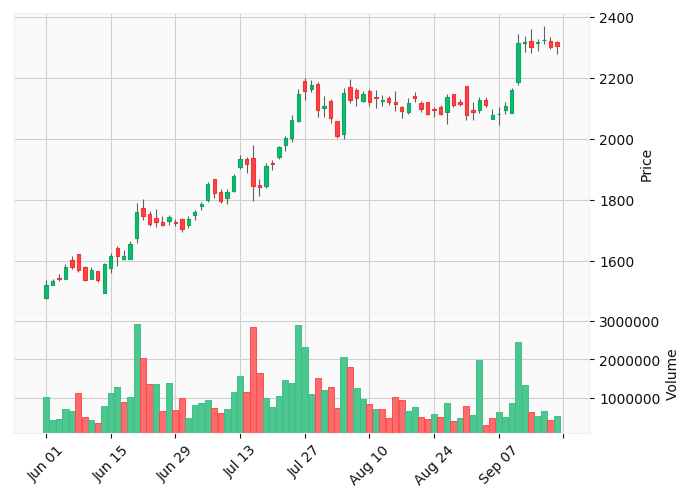

In [27]:
mpf.plot(df_updated.loc[datetime(2020,6,1):datetime(2020,9,18)],type='candle',style='yahoo',figsize=(8,6),volume=True)

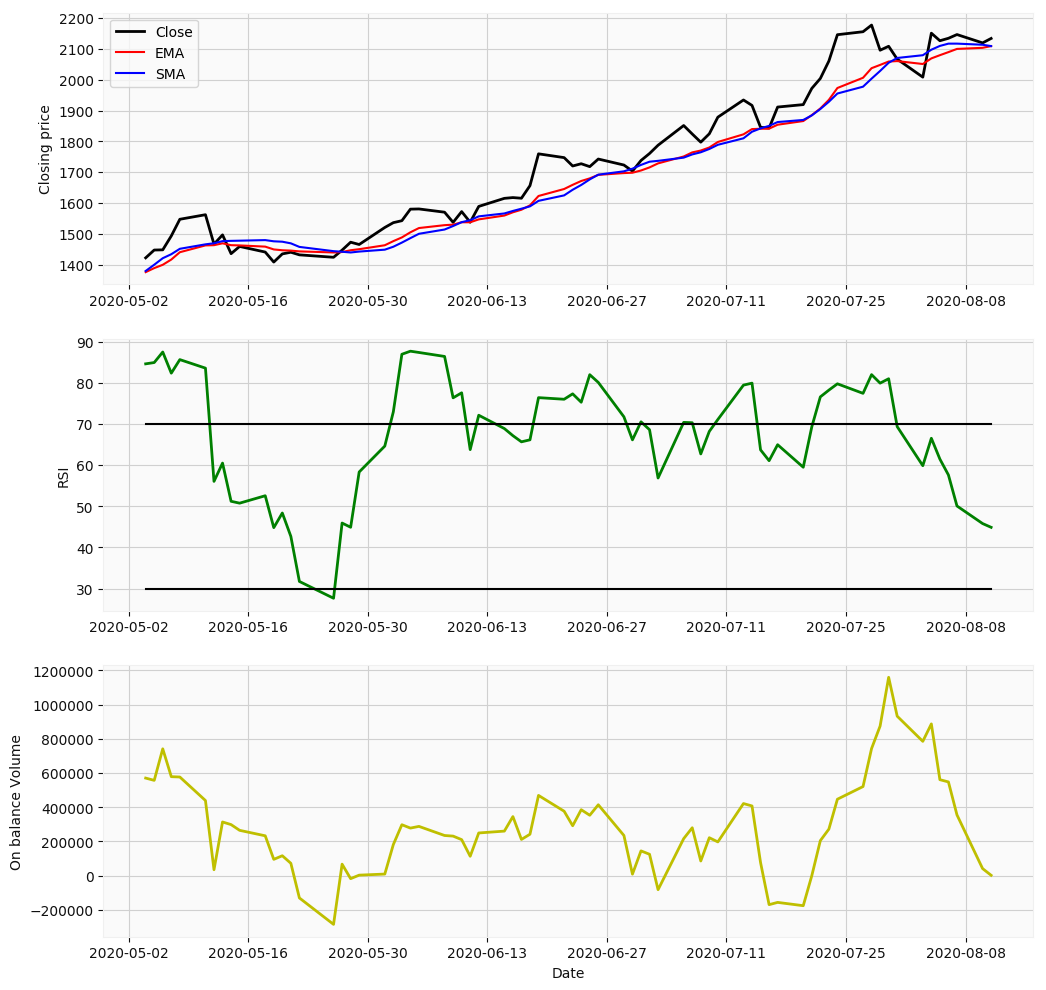

In [28]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,12))

ax[0].plot(df_updated['Close'].loc[datetime(2020,5,1):datetime(2020,8,11)],'k',lw=2,label='Close')
ax[0].plot(df_updated['EMA'].loc[datetime(2020,5,1):datetime(2020,8,11)],'r',lw=1.5,label='EMA')
ax[0].plot(df_updated['SMA'].loc[datetime(2020,5,1):datetime(2020,8,11)],'b',lw=1.5,label='SMA')
ax[0].set_ylabel('Closing price')

ax[0].legend()

temp = len(df_updated['RSI'].loc[datetime(2020,5,1):datetime(2020,8,11)])

ax[1].plot(df_updated['RSI'].loc[datetime(2020,5,1):datetime(2020,8,11)],'g',lw=2,label='RSI')
ax[1].plot(df_updated['RSI'].loc[datetime(2020,5,1):datetime(2020,8,11)].index,70*np.ones((temp,1)).flatten(),'k')
ax[1].plot(df_updated['RSI'].loc[datetime(2020,5,1):datetime(2020,8,11)].index,30*np.ones((temp,1)).flatten(),'k')
ax[1].set_ylabel('RSI')
#ax[1].legend()

ax[2].plot(df_updated['OBV'].loc[datetime(2020,5,1):datetime(2020,8,11)],'y',lw=2,label='OBV')
ax[2].set_ylabel('On balance Volume')
#ax[2].legend()
ax[2].set_xlabel('Date');

Indicators give us an idea of the direction of future prices. For instance, the Exponential moving average (EMA) crossing the Simple moving average (SMA) might indicate a positive uptrend in price. RSI gives us an idea of how much the stock is being bought or sold. An RSI of 70 for instance might indicate an overbought stock, and tells us the price is very likely to go down in the future, while an RSI of 30 indicates an oversold stock and could potentially be a good buy point for a stock. On balance volume gives us the relative changes in volume, and can potentially identify true rallies or breakouts. Bollinger bands provide an idea of the volatility of the stock.

We also want to take into account relative changes between trading days as they tend to be less volatile, and therefore a bit more stationary. We will take the difference between two consecutive days in this case.

In [29]:
df_updated['Diff_Open'] = df_updated['Open'] - df_updated['Open'].shift(1)
df_updated['Diff_Close'] = df_updated['Close'] - df_updated['Close'].shift(1)
df_updated['Diff-Volume']  = df_updated['Volume'] - df_updated['Volume'].shift(1)
df_updated['Diff-High']  = df_updated['High'] - df_updated['High'].shift(1)
df_updated['Diff-Low']  = df_updated['Low'] - df_updated['Low'].shift(1)
df_updated['Diff-Close (forward)'] = np.where(df_updated['Close'].shift(-1) > df_updated['Close'],1,-1)

df_updated['High-Low'] = df_updated['High'] - df_updated['Low'].shift(1)
df_updated['Open-Close'] = df_updated['Open'] - df_updated['Close'].shift(1)

df_updated['Returns'] = df_updated['Open'].pct_change(1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [30]:
df_updated.head()

,High,Low,Open,Close,Volume,Adj Close,ser,SMA,EMA,Real Upper Band,...,OBV,Diff_Open,Diff_Close,Diff-Volume,Diff-High,Diff-Low,Diff-Close (forward),High-Low,Open-Close,Returns
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-21,487.000000,476.399994,478.000000,477.375000,580074.0,457.139191,10,457.595001,463.936147,488.101938,...,124046.0,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
2015-10-23,486.674988,475.399994,481.049988,477.924988,479590.0,457.665894,11,460.929999,466.479573,492.387771,...,230720.0,3.049988,0.549988,-100484.0,-0.325012,-1.000000,-1,10.274994,3.674988,0.006381
2015-10-26,481.500000,470.000000,479.024994,471.500000,302258.0,451.513184,12,463.762500,467.392378,493.147565,...,251089.4,-2.024994,-6.424988,-177332.0,-5.174988,-5.399994,-1,6.100006,1.100006,-0.004210
2015-10-27,473.875000,468.750000,470.899994,469.600006,285718.0,449.693756,13,466.120001,467.793765,492.842558,...,193635.0,-8.125000,-1.899994,-16540.0,-7.625000,-1.250000,-1,3.875000,-0.600006,-0.016962
2015-10-28,472.250000,465.174988,469.000000,468.625000,281212.0,448.760101,14,468.355002,467.944898,491.150833,...,140005.8,-1.899994,-0.975006,-4506.0,-1.625000,-3.575012,1,3.500000,-0.600006,-0.004035


In [31]:
df_updated.drop(['Adj Close'],axis=1,inplace=True)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


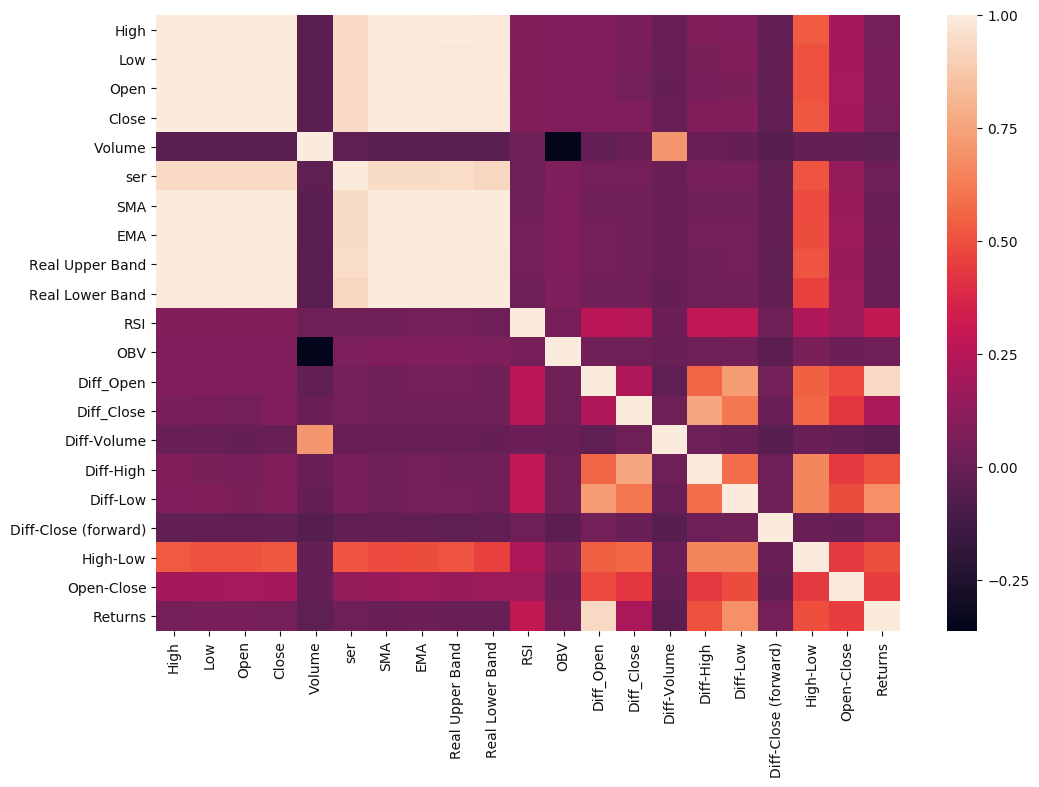

In [32]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.heatmap(df_updated.corr());

The closing price has very strong correlations with some of the other price informations such as opening price, highs and lows. On the other hands, the differential prices arn't as correlated. We want to limit the amount of colinearity in our system before running any machine learning routine. So feature selection is a must.

**Feature Selection**

We utilize mutual information gain. Information gain calculates the reduction in entropy from transforming a dataset in some way, it essentially evaluates the gain of each variable in the context of the target variable.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [34]:
# Seperate the target variable from the features
y = df_updated['Close'].iloc[1:].dropna()
X = df_updated.drop(['Close'],axis=1).iloc[1:].dropna()

In [35]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [36]:
X_train.shape, y_train.shape

((974, 20), (974,))

In [37]:
mi = mutual_info_regression(X_train,y_train)
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False,inplace=True)

In [38]:
mi

Low                     3.658513
High                    3.533054
Open                    2.927598
ser                     2.652626
EMA                     2.531731
Real Upper Band         2.501835
SMA                     2.373671
Real Lower Band         2.285152
OBV                     0.368707
High-Low                0.288507
Open-Close              0.172767
Diff_Open               0.164071
Diff-High               0.152053
Diff_Close              0.151810
Diff-Low                0.147949
RSI                     0.113160
Volume                  0.055964
Returns                 0.031643
Diff-Volume             0.000000
Diff-Close (forward)    0.000000
dtype: float64

In [39]:
sel = SelectKBest(mutual_info_regression, k = 7).fit(X_train, y_train) #
Features = X_train.columns[sel.get_support()]
Features.values

array(['High', 'Low', 'Open', 'ser', 'SMA', 'EMA', 'Real Upper Band'],
      dtype=object)

**Preprocessing**

In order to construct a Long short term memory neural network (LSTM), we need to understand its structure. Below is the design of a typical LSTM unit. Data source: Researchgate

As mentioned earlier, LSTM's are a special type of Recurrent neural networks (RNN). Recurrent neural networks (RNN) are a special type of neural network in which the output of a layer is fed back to the input layer multiple times in order to learn from the past data. Basically, the neural network is trying to learn data that follows a sequence. However, since the RNNs utilize past data, they can become computationally expensive due to storing large amouts of data in memory. The LSTM mitigates this issue, using gates. It has a cell state, and 3 gates; forget, imput and output gates.

The cell state is essentially the memory of the network. It carries information throughtout the data sequence processing. Information is added or removed from this cell state using gates. Information from the previous hidden state and current input are combined and passed through a sigmoid function at the forget gate. The sigmoid function determines which data to keep or forget. The transformed values are then multipled by the current cell state.

Next, the information from the previous hidden state combined with the input is passed through a sigmoid function to again determine important information, and also a tanh function to transform data between -1 and 1. This transformation helps with the stability of the network and helps deal with the vanishing/exploding gradient problem. These 2 outputs are multiplied together, and the output is added to the current cell state with the sigmoid function applied to it to give us our new cell state for the next time step.

Finally, the information from the hidden state combined with the current input are combined and a sigmoid function applied to it. The new cell state is passed through a tanh function to transform the values and both outputs are multiplied to determine the new hidden state for the next time step.

Now we have an idea of how the LSTM works, let's construct one. First we split our data into training and test set

In [40]:
df_updated.reset_index(drop=True,inplace=True)

train_size = int(len(df_updated) * 0.8)
test_size =  len(df_updated) - train_size

# Make sure to omit the first row, contains NAN's
train = df_updated.iloc[1:train_size]
test = df_updated.iloc[train_size:]

In [41]:
train.shape, test.shape

((974, 21), (244, 21))

In [42]:
# Extract the features
total_features = list(Features.values)

total_features.append('Close')
total_features


train = train[total_features]
test = test[total_features]

train.shape,test.shape

((974, 8), (244, 8))

Before we proceed, it is important to scale the data. Scaling is done to ensure one set of features don't have more importance relative to the others. In addition, having values between 0 and 1 will help the neural network converge faster if at all it does. We apply different scalings to the test and training data to avoid leakage into our model.


In [43]:
# Scale both features and target variables

f_transformer = MinMaxScaler() # Feature scaler
targ_transformer = MinMaxScaler() # Target scaler


f_transformer = f_transformer.fit(train[Features].to_numpy())
targ_transformer = targ_transformer.fit(train[['Close']])

train.loc[:,Features] = f_transformer.transform(train[Features].to_numpy())
train['Close'] = targ_transformer.transform(train[['Close']].to_numpy())

test.loc[:,Features] = f_transformer.transform(test[Features].to_numpy())
test['Close'] = targ_transformer.transform(test[['Close']].to_numpy())

Bassically for data at time t, with a window size of N, the target feature will be the data point at time t, and the feature will be the data points [t-1, t-N]. We then sequentially move forward in time using this approach. We therefore need to format our data that way.

In [44]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [140]:
#time_steps = 10

#X_train_lstm, y_train_lstm = create_dataset(train.drop(['Close'],axis=1), train['Close'], time_steps)
#X_test_lstm, y_test_lstm = create_dataset(test.drop(['Close'],axis=1), test['Close'], time_steps)

In [45]:
time_steps = 10

X_train_lstm, y_train_lstm = create_dataset(train[['ser','Close']], train['Close'], time_steps)
X_test_lstm, y_test_lstm = create_dataset(test[['ser','Close']], test['Close'], time_steps)

In [46]:
X_train_lstm.shape, y_train_lstm.shape

((964, 10, 2), (964,))

In [47]:
X_test_lstm.shape, y_test_lstm.shape

((234, 10, 2), (234,))

**Building LSTM Network**

In [48]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Bidirectional(
        keras.layers.LSTM(
          units=32, 
          input_shape=(X_train_lstm.shape[1],X_train_lstm.shape[2]))
  )
)

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

In [49]:
training = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=90,
    batch_size=40,
    validation_split=0.2,
    shuffle=False,
    verbose=1
)

Epoch 1/90
20/20 [==============================] - 2s 104ms/step - loss: 0.0087 - val_loss: 0.0061
Epoch 2/90
20/20 [==============================] - 0s 15ms/step - loss: 0.0271 - val_loss: 0.0143
Epoch 3/90
20/20 [==============================] - 0s 13ms/step - loss: 0.0078 - val_loss: 0.0047
Epoch 4/90
20/20 [==============================] - 0s 17ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 5/90
20/20 [==============================] - 0s 17ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 6/90
20/20 [==============================] - 0s 18ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 7/90
20/20 [==============================] - 0s 14ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 8/90
20/20 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 9/90
20/20 [==============================] - 0s 16ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 10/90
20/20 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 11

Epoch 83/90
20/20 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 84/90
20/20 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 85/90
20/20 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 86/90
20/20 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 87/90
20/20 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 88/90
20/20 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 89/90
20/20 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 90/90
20/20 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0015


In [50]:
test_loss = model.evaluate(X_test_lstm,y_test_lstm)
print(test_loss)

8/8 [==============================] - 0s 6ms/step - loss: 0.0137
0.013710029423236847


In [51]:
def plot_learningCurve(history,epoch_num):  
  
    epoch_range = range(1,epoch_num+1)

    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','val'], loc='upper left')
    plt.show()

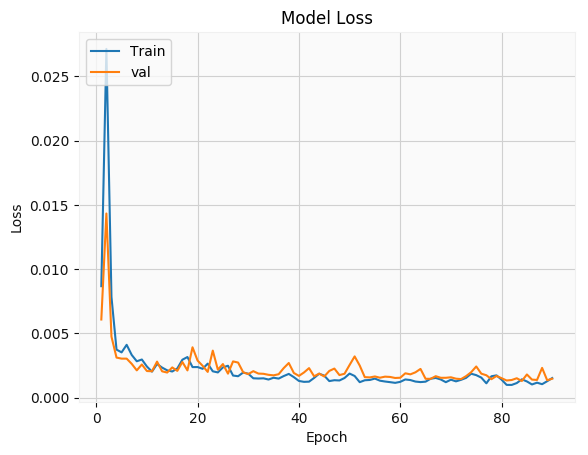

In [52]:
plot_learningCurve(training,90)

**Prediction**

In [53]:
y_pred = model.predict(X_test_lstm)

**Inverse Scaling**

In [54]:
y_train_inv = targ_transformer.inverse_transform(y_train_lstm.reshape(1, -1))
y_test_inv = targ_transformer.inverse_transform(y_test_lstm.reshape(1, -1))
y_pred_inv = targ_transformer.inverse_transform(y_pred)

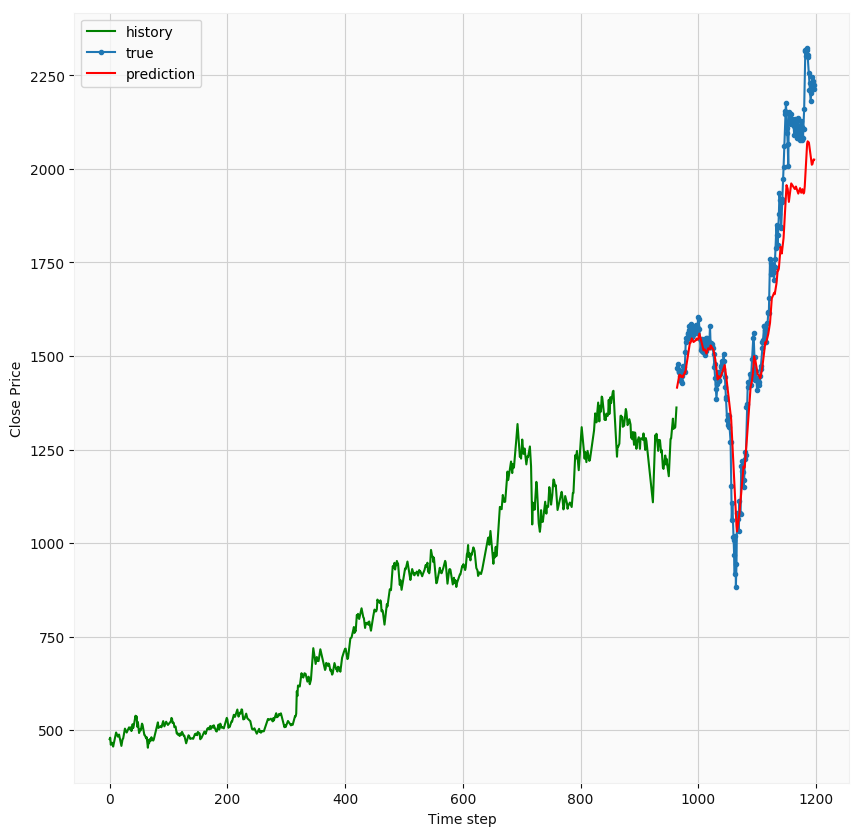

In [55]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, len(y_train_lstm)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train_lstm,), len(y_train_lstm) + len(y_test_lstm)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train_lstm), len(y_train_lstm) + len(y_test_lstm)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Close Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

In [56]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("rel_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("rel_model.h5")
print("Saved model to disk")

Saved model to disk
